This notebook plots all placefield tuning curves to PDFs for inspection and calculates peaks and widths for each field.

It saves group placefield statistics as well.

In [ ]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
if platform.system() == "Darwin":
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
    sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])
    
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter

from neuropy import plotting
from neuropy.core.epoch import Epoch
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.core.position import Position
from neuropy.plotting import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

## TO-DO 12/12:
0) ~Dump firing rate for each peak into data_df!~
1) ~Figure out how to do between session correlations easily (may need to redo inheritance stuff for resample_1D)~
2) ~Re-plot all fields with odd-even and b/w correlations~

3) Re-do place field stats after removing low reliability and low firing rate cells:  
        - b/w sesh corrs  
        - delta FR peak index  
        - delta peak loc  
        - # peaks between sessions  
        - average width between sessions  
        - width of biggest peak between sessions  


### Define sessions

In [2]:
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info

### Example code to analyze placefield peaks and widths

In [3]:
# Use this code to quickly load placefields and test out things
sess = sessions[7]  # Session 7 has lowest number of neurons

maze = sess.paradigm["maze"].flatten()  # Grab times when rat was on the maze (as opposed to pre/post sleep recordings)
remaze = sess.paradigm["remaze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")  # get pre-selected stable neurons
kw = dict(frate_thresh=0, grid_bin=5)  # Define placefield parameters

pfmaze = Pf1D(neurons, position=sess.maze, **kw)
pfremaze = Pf1D(neurons, position=sess.remaze, **kw)

# Use this to test with first 5 placefield
# pf_maze_data_df = pfmaze.neuron_slice(inds=np.arange(5)).get_pf_data(step=0.1, height_thresh=0.75, plot=False)
# pf_remaze_data_df = pfremaze.neuron_slice(inds=np.arange(5)).get_pf_data(step=0.1, height_thresh=0.75, plot=False)

# Grab all fields here
pf_maze_data_df = pfmaze.get_pf_data(step=0.1, height_thresh=0.75, plot=False)
pf_remaze_data_df = pfremaze.get_pf_data(step=0.1, height_thresh=0.75, plot=False)

### Plot all placefield tuning curves with rasters for each session, mapped between MAZE and reMAZE
Save to multi-page PDF in groupdata folder

In [9]:
%matplotlib widget
from matplotlib.backends.backend_pdf import PdfPages
from tqdm import tqdm
sigma_pre = 0  # Smoothing done for occupancy and spike counts BEFORE creating maps
sigma2 = 1.5  # additional smoothing for calculating placefield widths, done in bin units, AFTER tuning curve is created
height_thresh = 0.75

for sess in tqdm(sessions):
    maze = sess.paradigm["maze"].flatten()  # Grab times when rat was on the maze (as opposed to pre/post sleep recordings)
    remaze = sess.paradigm["remaze"].flatten()
    neurons = sess.neurons_stable.get_neuron_type("pyr")  # get pre-selected stable neurons
    kw = dict(frate_thresh=0, grid_bin=5, sigma=sigma_pre)  # Define placefield parameters
    
    pfmaze = Pf1D(neurons, position=sess.maze, **kw)
    pfremaze = Pf1D(neurons, position=sess.remaze, **kw)
    
    # Use this to test with first 5 placecells
    # pf_maze_data_df = pfmaze.neuron_slice(inds=np.arange(5)).get_pf_data(step=0.1, height_thresh=height_thresh, plot=False)
    # pf_remaze_data_df = pfremaze.neuron_slice(inds=np.arange(5)).get_pf_data(step=0.1, height_thresh=height_thresh, plot=False)
    
    # Grab all fields here
    pf_maze_data_df = pfmaze.get_pf_data(step=0.1, height_thresh=height_thresh, plot=False)
    pf_remaze_data_df = pfremaze.get_pf_data(step=0.1, height_thresh=height_thresh, plot=False)

    # Calculate maze-remaze corrs - need to resize tuning curves to match! Not currently working, need to resize tuning curves to match shape
    bw_corrs = []
    for tcm, tcrm in zip(pfmaze.resample_1D(50).smooth_tuning_curves(sigma_bin=sigma2), 
                         pfremaze.resample_1D(50).smooth_tuning_curves(sigma_bin=sigma2)):
        bw_corrs.append(np.corrcoef(tcm, tcrm)[0, 1])
    bw_corrs = np.array(bw_corrs)

    # Add in reliability information along with between session corrs
    pfmaze_split = Pf1Dsplit(neurons, position=sess.maze, t_interval_split=60, **kw)
    maze_corrs = pfmaze_split.get_correlations(sigma_bin=sigma2)
    pfremaze_split = Pf1Dsplit(neurons, position=sess.remaze, t_interval_split=60, **kw)
    remaze_corrs = pfremaze_split.get_correlations(sigma_bin=sigma2)
    # nids = pf_maze_data_df.cell_id.unique()
    nids = pfmaze_split.pf1.neuron_ids
    for cell_id in nids:
        pf_maze_data_df.loc[pf_maze_data_df.cell_id == cell_id, "r_odd_even"] = maze_corrs[nids == cell_id].squeeze()
        pf_maze_data_df.loc[pf_maze_data_df.cell_id == cell_id, "r_maze_remaze"] = bw_corrs[nids == cell_id].squeeze()
        pf_remaze_data_df.loc[pf_remaze_data_df.cell_id == cell_id, "r_odd_even"] = remaze_corrs[nids == cell_id].squeeze()
        pf_remaze_data_df.loc[pf_remaze_data_df.cell_id == cell_id, "r_maze_remaze"] = bw_corrs[nids == cell_id].squeeze()

    # Save pf stats dataframes as csv
    pf_maze_data_df["session"] = "MAZE"
    pf_remaze_data_df["session"] = "reMAZE"
    pf_stats_comb_df = pd.concat((pf_maze_data_df, pf_remaze_data_df), axis=0, ignore_index=True)
    stats_savename = sess.basepath / f"pf_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}.csv"
    pf_stats_comb_df.to_csv(stats_savename)
    
    # Loop through each field and plot to multi-page PDF
    savename = subjects.Group.basedir / f"{sess.name}{sess.tag}_placefields.pdf" 
    with PdfPages(savename) as pdf:
        fig, ax = plt.subplots(figsize=(9, 4))
        ax.plot(sess.position.x, sess.position.y)
        pdf.savefig()
        for cell_id in pf_maze_data_df.cell_id.unique():
            
            fig, ax = plt.subplots(2, 2, figsize=(9, 4), sharex=True, height_ratios=(3, 3))
            
            for a, pf_use, pf_data_df, title in zip(ax.T, [pfmaze, pfremaze], [pf_maze_data_df, pf_remaze_data_df], ["MAZE", "reMAZE"]):
                pf_use = pf_use.neuron_slice(ids=[cell_id])
                df_use = pf_data_df[pf_data_df.cell_id == cell_id].reset_index()
            
                # fig.suptitle(f"Cell_id = {cell_id}")
                if title == "MAZE":
                    fig.suptitle(f"Cell_id = {cell_id}, r_maze_remaze={df_use['r_maze_remaze'][0]:.2f}")
                
                pf_use.plot_pf_peaks_and_widths(pf_use.smooth_tuning_curves(sigma_bin=sigma2).squeeze(), df_use["width_bin"], 
                                               df_use[["left_edge", "right_edge"]].values, df_use["height"], 
                                               df_use["prominence"], df_use["center_bin"], height_thresh=0.75, ax=a[0])
                
                pf_use.plot_rasters(plot_time=True, scale="tuning_curve", ax=a[1])
                try:
                    a[0].set_title(f"{title} rho_odd_even={df_use['r_odd_even'][0]:.2f}")
                except KeyError:
                    pass
            
            pdf.savefig()
            plt.close()

  0%|                                                     | 0/8 [00:00<?, ?it/s]/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 12%|█████▌                                      | 1/8 [03:26<24:02, 206.02s/it]

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 25%|███████████                                 | 2/8 [04:23<11:52, 118.73s/it]/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 38%|████████████████▉                            | 3/8 [05:18<07:28, 89.62s/it]

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 50%|██████████████████████▌                      | 4/8 [06:27<05:25, 81.48s/it]

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


 62%|████████████████████████████▏                | 5/8 [07:23<03:37, 72.39s/it]/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/Users/nkinsky/mambaforge/envs/NeuroPy/lib/python3.11/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
 75%|█████████████████████████████████▊           | 6/8 [09:17<02:52, 86.34s/it]

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


 88%|███████████████████████████████████████▍     | 7/8 [10:22<01:19, 79.41s/it]

Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided
Note: speed_thresh is ignored when epochs is provided


100%|█████████████████████████████████████████████| 8/8 [11:30<00:00, 86.29s/it]


##### Save group data

In [31]:
stats_all_df = []
for sess in sessions:
    # Load in dataframe
    stats_savename = sess.basepath / f"pf_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}.csv"
    sesh_df = pd.read_csv(stats_savename, index_col=0)
    
    # Add in session info
    sesh_df["animal"] = sess.animal.name
    sesh_df["day"] = sess.animal.day
    sesh_df["grp"] = sess.tag

    # combine
    stats_all_df.append(sesh_df)

stats_all_df = pd.concat(stats_all_df, axis=0, ignore_index=True)
grp_savename = subjects.Group.basedir / f"placefield_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}.csv"
stats_all_df.to_csv(grp_savename)
stats_all_df

,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,session,animal,day,grp
0,7,0,5.100088,5.100088,45.978354,2.081165,44.918835,NaN,0.647907,-0.223848,MAZE,RatU,Day2,NSD
1,7,1,1.000088,1.000000,22.004805,2.504978,21.005938,23.510916,0.647907,-0.223848,MAZE,RatU,Day2,NSD
2,7,2,0.400088,0.400000,3.142314,4.414027,0.839603,5.253630,0.647907,-0.223848,MAZE,RatU,Day2,NSD
3,7,3,0.400088,0.200000,37.014362,2.388710,35.873396,38.262106,0.647907,-0.223848,MAZE,RatU,Day2,NSD
4,9,0,0.300000,0.300000,0.684758,2.159727,NaN,2.159727,0.406690,0.214475,MAZE,RatU,Day2,NSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2517,55,1,4.700000,0.900000,26.472719,1.938665,25.483065,27.421730,0.679301,0.662455,reMAZE,RatR,Day2,SD
2518,55,2,3.200000,3.200000,84.533367,4.132923,82.867077,NaN,0.679301,0.662455,reMAZE,RatR,Day2,SD
2519,55,3,1.300000,1.300000,61.436256,4.137539,59.244285,63.381824,0.679301,0.662455,reMAZE,RatR,Day2,SD
2520,59,0,0.400000,0.400000,23.036796,3.435601,21.347985,24.783586,-0.122792,0.490445,reMAZE,RatR,Day2,SD


### Evaluate placefield reliability
- easiest - calculate correlation between tuning curves calculated from odd vs even minutes for each cell

#### PF corrs

##### First plot all without thresholding anything

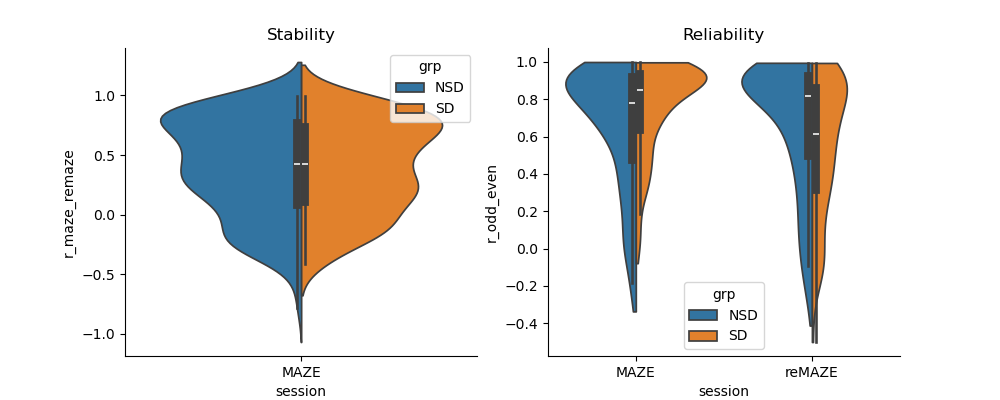

In [57]:
corrs_df = stats_all_df.groupby(["grp", "animal", "day", "cell_id", "session"]).mean(numeric_only=True).reset_index()
corrs_df

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.violinplot(data=corrs_df[corrs_df.session == "MAZE"], x="session", y="r_maze_remaze", hue="grp", split=True, ax=ax[0])
ax[0].set_title('Stability')

sns.violinplot(data=corrs_df, x="session", y="r_odd_even", hue="grp", dodge=True, split=True, cut=0, ax=ax[1])
ax[1].set_title('Reliability')

sns.despine(fig=fig)

##### Now plot cells that meet firing rate threshold - note this is done by each track independently, so different cells could be included!

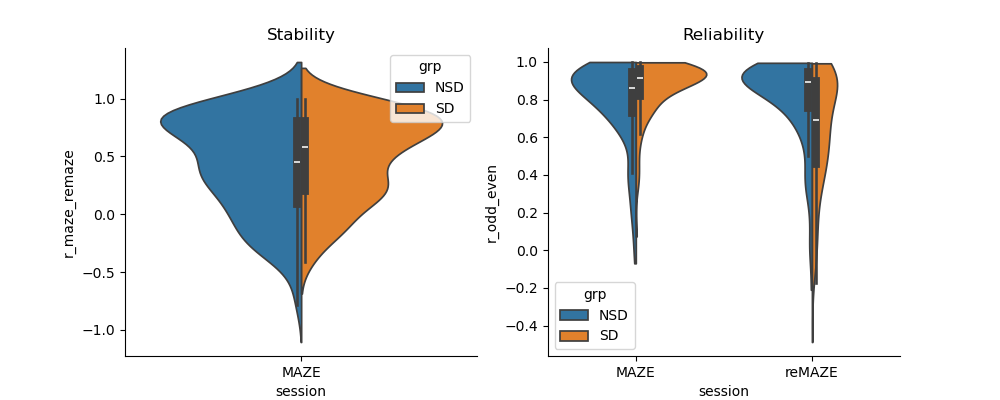

In [64]:
frate_thresh = 1.5  # From Wang, Monaco, Knierim 2020 (Curr. Bio)

# First, get rid of any cells without at least one field greater than frate_thresh (note these could be different cells from MAZE to reMAZE)
frate_thresh_df = stats_all_df[stats_all_df.height > frate_thresh]

corrs_df = frate_thresh_df.groupby(["grp", "animal", "day", "cell_id", "session"]).mean(numeric_only=True).reset_index()

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.violinplot(data=corrs_df[corrs_df.session == "MAZE"], x="session", y="r_maze_remaze", hue="grp", split=True, ax=ax[0])
ax[0].set_title('Stability')

sns.violinplot(data=corrs_df, x="session", y="r_odd_even", hue="grp", dodge=True, split=True, cut=0, ax=ax[1])
ax[1].set_title('Reliability')

sns.despine(fig=fig)


In [76]:
# First reshape things to make your life easy
corrs_df_trim = corrs_df.drop(columns=["peak_no", "height", "prominence", "center_bin", "width_bin", "left_edge", "right_edge"])
corrs_df_rs = corrs_df_trim.pivot(index=["grp", "animal", "day", "cell_id"], columns="session", values=["r_odd_even", "r_maze_remaze"]).reset_index()
corrs_df_rs

grp animal   day cell_id r_odd_even           r_maze_remaze          
session                                 MAZE    reMAZE          MAZE    reMAZE
0        NSD   RatU  Day2       7   0.647907  0.499792     -0.223848 -0.223848
1        NSD   RatU  Day2      11   0.828705  0.976825      0.574304  0.574304
2        NSD   RatU  Day2      13   0.978270       NaN      0.957284       NaN
3        NSD   RatU  Day2      15   0.988319  0.922438      0.838046  0.838046
4        NSD   RatU  Day2      17   0.262508       NaN     -0.148962       NaN
..       ...    ...   ...     ...        ...       ...           ...       ...
335       SD   RatV  Day2      86   0.928046  0.982102      0.870297  0.870297
336       SD   RatV  Day2      88        NaN  0.958972           NaN  0.248444
337       SD   RatV  Day2      95   0.975148       NaN      0.669705       NaN
338       SD   RatV  Day2      97        NaN  0.949887           NaN  0.709306
339       SD   RatV  Day2     102   0.897934       NaN      0.728878       NaN

[340 rows x 8 columns]

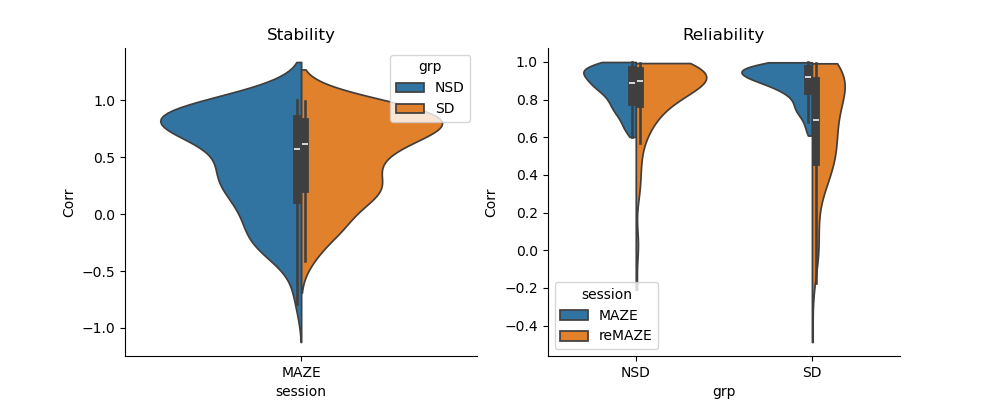

In [168]:
rel_thresh = 0.6  # eyeball to cut off bottom tail...

top_rel_df = corrs_df_rs[corrs_df_rs["r_odd_even"]["MAZE"] > rel_thresh]
top_rel_df = top_rel_df.melt(id_vars=["grp", "animal", "day", "cell_id"], var_name=["corr_type", "session"], value_name="Corr")
bot_rel_df = corrs_df_rs[corrs_df_rs["r_odd_even"]["MAZE"] < rel_thresh]

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
sns.violinplot(data=top_rel_df[(top_rel_df.session == "MAZE") & (top_rel_df.corr_type == "r_maze_remaze")], 
               x="session", y="Corr", hue="grp", split=True, ax=ax[0])
ax[0].set_title('Stability')

sns.violinplot(data=top_rel_df[top_rel_df.corr_type == "r_odd_even"], 
               x="grp", y="Corr", hue="session", dodge=True, split=True, cut=0, ax=ax[1])
ax[1].set_title('Reliability')

sns.despine(fig=fig)


In [176]:
# Is the above driven by one session in SD? No, all but one session has a big drop, whereas NSD sessions only exhibit small drops.
top_rel_df[ (top_rel_df.corr_type == "r_odd_even")].drop(columns="cell_id").groupby(["grp", "animal", "day", "corr_type", "session"]).mean()

Corr
grp animal day  corr_type  session          
NSD RatU   Day2 r_odd_even MAZE     0.856988
                           reMAZE   0.800658
    RatV   Day1 r_odd_even MAZE     0.815312
                           reMAZE   0.792132
           Day3 r_odd_even MAZE     0.918244
                           reMAZE   0.910777
SD  RatR   Day2 r_odd_even MAZE     0.862507
                           reMAZE   0.690383
    RatS   Day3 r_odd_even MAZE     0.889474
                           reMAZE   0.786597
    RatU   Day1 r_odd_even MAZE     0.879393
                           reMAZE   0.342306
           Day4 r_odd_even MAZE     0.890453
                           reMAZE   0.542784
    RatV   Day2 r_odd_even MAZE     0.924098
                           reMAZE   0.922818

<Axes: xlabel='height', ylabel='Count'>

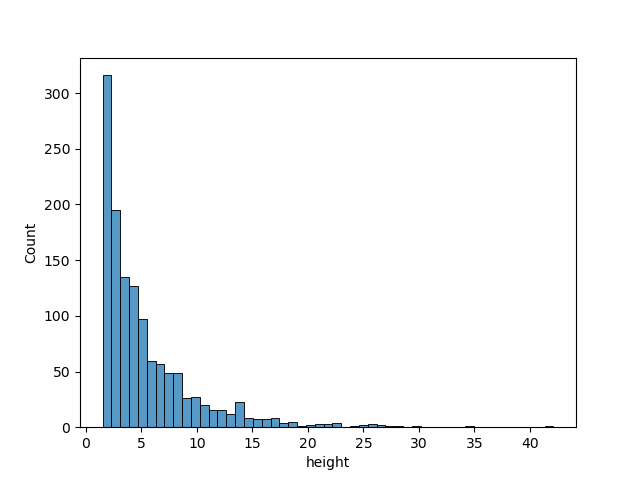

In [60]:
_, ax = plt.subplots()
sns.histplot(data=frate_thresh_df, x="height", ax=ax)

In [ ]:
sess = sessions[0]

maze = sess.paradigm["maze"].flatten()  # Grab times when rat was on the maze (as opposed to pre/post sleep recordings)
remaze = sess.paradigm["re-maze"].flatten()
neurons = sess.neurons_stable.get_neuron_type("pyr")  # get pre-selected stable neurons
kw = dict(frate_thresh=0, grid_bin=5)  # Define placefield parameters

maze_odd = np.arange
pfmaze = Pf1D(neurons, position=sess.maze, **kw)
pfremaze = Pf1D(neurons, position=sess.remaze, **kw)